In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install classla

In [8]:
import classla

classla.download('sr')   # download standard models for Slovenian, use hr for Croatian, sr for Serbian, bg for Bulgarian, mk for Macedonian

/usr/local/lib/python3.10/dist-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
INFO:classla:Downloading these customized packages for language: sr (Serbian)...
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |
| depparse  | standard |
| ner       | standard |
| pretrain  | standard |

INFO:classla:Finished downloading models and saved to /root/classla_resources.


In [9]:
import pandas as pd

file_path = '/content/drive/MyDrive/PhD/Surprisal estimation/wordlist_classlawiki_sr_20240122114347.csv'
freq_df = pd.read_csv(file_path, )

freq_df

,word,freq
0,.,6438580
1,",",5916591
2,biti,5835707
3,u,4289454
4,i,2848044
...,...,...
345260,"0,024",5
345261,#43,5
345262,#42,5
345263,#154,5


In [11]:
target_sentences_df = pd.read_csv('/content/drive/MyDrive/PhD/Transcript - correct/target_sentences.csv')
target_sentences_df

,Text
0,još malo pa će izbori
1,naoblačilo se kao da će padati kiša
2,naša kola su stara 10 godina
3,otišao je u inostranstvo prošle godine i još s...
4,telefoni zvone po ceo dan i tebe traže
...,...
62,pojavio se u poslednjem trenutku
63,sanjao sam te pre neku noć
64,premijer je obećao viši standard
65,sutra je doček Nove Godine


In [12]:
nlp = classla.Pipeline('sr', processors='tokenize, lemma, pos')

INFO:classla:Loading these models for language: sr (Serbian):
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |

INFO:classla:Use device: cpu
INFO:classla:Loading: tokenize
INFO:classla:Loading: pos
INFO:classla:Loading: lemma
INFO:classla:Done loading processors!


In [18]:
words_list = []
frequency_list = []
target_sentence_list = []
lemma_list = []
alpha = 1 # Laplace smoothing
num_new_words = 0

for i in range(0,len(target_sentences_df)):
  sentence = target_sentences_df['Text'][i].lower()
  words = sentence.split(' ')

  for word in words:
    if word == '':
      continue
    words_list.append(word)
    target_sentence_list.append(i)

    doc = nlp(word)     # run the pipeline
    lemma = doc.to_conll().split()[-8]
    lemma_list.append(lemma)

    filtered_df = freq_df[freq_df['word'] == lemma]
    # Extract the frequency and word from the filtered DataFrame
    if not filtered_df.empty:
      frequency = filtered_df['freq'].values[0]
      frequency_list.append(frequency)
    else:
      frequency_list.append(alpha)
      num_new_words += 1

In [24]:
import math

total_freq = sum(freq_df['freq']) + (num_new_words + len(freq_df)) * alpha
log_probability_list = [math.log(freq / total_freq) for freq in frequency_list]

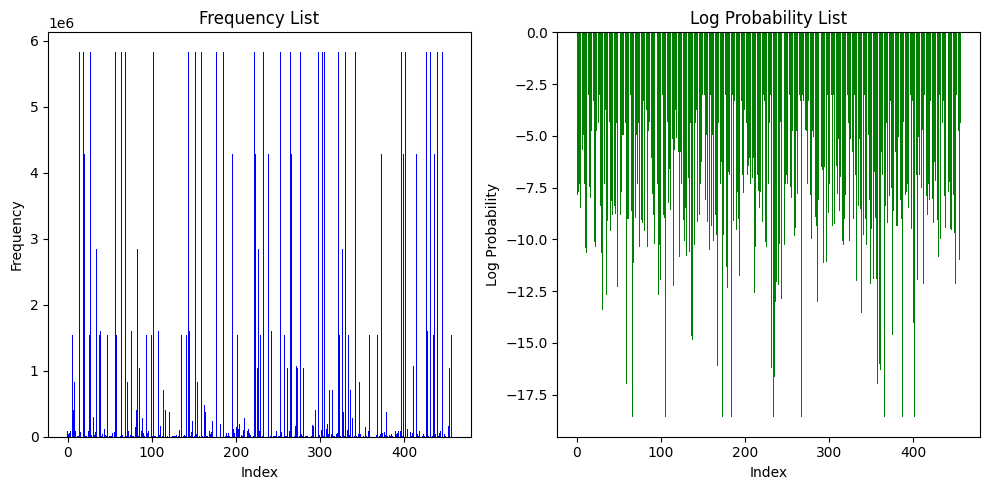

In [25]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))

# Plot Frequency
plt.subplot(1, 2, 1)
plt.bar(range(len(frequency_list)), frequency_list, color='blue')
plt.title('Frequency List')
plt.xlabel('Index')
plt.ylabel('Frequency')

# Plot Log Probabilities
plt.subplot(1, 2, 2)
plt.bar(range(len(log_probability_list)), log_probability_list, color='green')
plt.title('Log Probability List')
plt.xlabel('Index')
plt.ylabel('Log Probability')

plt.tight_layout()
plt.show()

In [26]:
# Create a DataFrame
df = pd.DataFrame({'Sentence': target_sentence_list,
                   'Word': words_list,
                   'Lemma': lemma_list,
                   'Word Frequency': frequency_list,
                   'Log Probability': log_probability_list})
df.to_csv('/content/drive/MyDrive/PhD/Surprisal estimation/wordlist_frequencies.csv', index=False)

# Display the DataFrame
print(df)

     Sentence    Word   Lemma  Word Frequency  Log Probability
0           0     još     još           79420        -7.325636
1           0    malo    malo           46780        -7.854931
2           0      pa      pa           54554        -7.701195
3           0      će   hteti           80522        -7.311856
4           0  izbori   izbor           25014        -8.480951
..        ...     ...     ...             ...              ...
452        65   doček   doček             347       -12.758817
453        65    nove     nov          162134        -6.611963
454        65  godine  godina         1038137        -4.755203
455        66   nadam  nadati            1992       -11.011247
456        66      se    sebe         1544095        -4.358193

[457 rows x 5 columns]
